In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



In [3]:
chroma_df = pd.read_csv('results_chroma.csv')
chroma_df['Model'] = ['Chroma' for i in range(len(chroma_df))]
qdrant_df = pd.read_csv('results_qdrant.csv')
chroma_df['Model'] = ['Qdrant' for i in range(len(chroma_df))]
redis_df = pd.read_csv('results_redis.csv')
redis_df['Model'] = ['Redis' for i in range(len(chroma_df))]
redis_df.head()

,Unnamed: 0,Chunk Size,Overlap,Embedding Model,Query,Vector DB,Query Time (s),Memory Used,LLM Model,LLM Response,Model
0,0,200,0,nomic-embed-text,What is redis?,redis,174.624804,237479,llama2,role='assistant' content='Redis (short for REA...,Redis
1,0,200,0,nomic-embed-text,What is an AVL tree?,redis,113.337713,210020,llama2,role='assistant' content='An AVL tree is a sel...,Redis
2,0,200,0,nomic-embed-text,How do document databases like MongoDB differ ...,redis,206.388777,211737,llama2,"role='assistant' content='Document databases, ...",Redis
3,0,200,0,nomic-embed-text,What are tradeoffs between B+ Trees and LSM?,redis,259.517095,211461,llama2,role='assistant' content='B+ trees and Log-Str...,Redis
4,0,200,0,sentence-transformers/all-MiniLM-L6-v2,What is redis?,redis,158.155374,5835849,llama2,role='assistant' content='\nRedis is an in-mem...,Redis


In [4]:
chroma_qry_avg = chroma_df.groupby('Query')[['Memory Used', 'Query Time (s)']].mean()
chroma_qry_avg.rename(columns= {'Memory Used':'Chroma Memory', 'Query Time (s)':'Chroma Runtime'}, inplace=True)
qdrant_qry_avg = qdrant_df.groupby('Query')[['Memory Used', 'Query Time (s)']].mean()
qdrant_qry_avg.rename(columns= {'Memory Used':'Qdrant Memory', 'Query Time (s)':'Qdrant Runtime'}, inplace=True)
redis_qry_avg = redis_df.groupby('Query')[['Memory Used', 'Query Time (s)']].mean()
redis_qry_avg.rename(columns= {'Memory Used':'Redis Memory', 'Query Time (s)':'Redis Runtime'}, inplace=True)
merged_avgs = chroma_qry_avg.merge(qdrant_qry_avg, how='left', on='Query')
merged_avgs.reset_index(inplace=True)
merged_avgs = redis_qry_avg.merge(merged_avgs, how='left', on='Query')
merged_avgs.reset_index(inplace=True)
merged_avgs


,index,Query,Redis Memory,Redis Runtime,Chroma Memory,Chroma Runtime,Qdrant Memory,Qdrant Runtime
0,0,How do document databases like MongoDB differ ...,4.026276e+06,207.532508,4.056489e+06,86.701187,4.040086e+06,322.262437
1,1,What are tradeoffs between B+ Trees and LSM?,4.029756e+06,820.146347,4.055761e+06,137.903510,4.037765e+06,179.875259
2,2,What is an AVL tree?,4.033208e+06,142.161088,4.055973e+06,62.318876,4.041120e+06,76.266764
3,3,What is redis?,4.038004e+06,127.158843,4.041169e+06,76.007340,4.047262e+06,137.920880


In [5]:
px.bar(merged_avgs,x='Query', y=['Chroma Memory', 'Qdrant Memory', 'Redis Memory'], barmode='group')

In [6]:
px.bar(merged_avgs,x='Query', y=['Chroma Runtime', 'Qdrant Runtime', 'Redis Runtime'], barmode='group')

Text(0, 0.5, 'Query Time (s)')

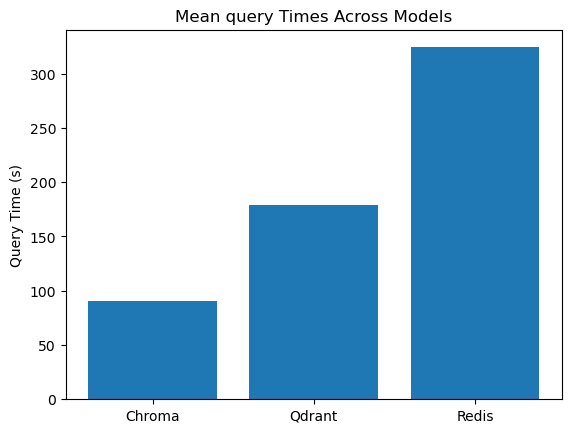

In [7]:
plt.bar(x=['Chroma', 'Qdrant', 'Redis'], height=[chroma_df['Query Time (s)'].mean(), qdrant_df['Query Time (s)'].mean(), redis_df['Query Time (s)'].mean()])
plt.title('Mean query Times Across Models')
plt.ylabel('Query Time (s)')

In [8]:
chroma_embd_avg = chroma_df.groupby('Embedding Model')[['Memory Used', 'Query Time (s)']].mean()
chroma_embd_avg.rename(columns= {'Memory Used':'Chroma Memory', 'Query Time (s)':'Chroma Runtime'}, inplace=True)
qdrant_embd_avg = qdrant_df.groupby('Embedding Model')[['Memory Used', 'Query Time (s)']].mean()
qdrant_embd_avg.rename(columns= {'Memory Used':'Qdrant Memory', 'Query Time (s)':'Qdrant Runtime'}, inplace=True)
redis_embd_avg = redis_df.groupby('Embedding Model')[['Memory Used', 'Query Time (s)']].mean()
redis_embd_avg.rename(columns= {'Memory Used':'Redis Memory', 'Query Time (s)':'Redis Runtime'}, inplace=True)
merged_embd = chroma_embd_avg.merge(qdrant_embd_avg, how='left', on='Embedding Model')
merged_embd.reset_index(inplace=True)
merged_embd = redis_embd_avg.merge(merged_embd, how='left', on='Embedding Model')
merged_embd.reset_index(inplace=True)
merged_embd

,index,Embedding Model,Redis Memory,Redis Runtime,Chroma Memory,Chroma Runtime,Qdrant Memory,Qdrant Runtime
0,0,nomic-embed-text,213838.625,165.950549,278965.250,102.220810,251069.500,130.794042
1,1,sentence-transformers/all-MiniLM-L6-v2,5827001.500,179.668311,5818342.125,77.270156,5821131.375,263.350132
2,2,sentence-transformers/all-mpnet-base-v2,6054593.250,627.130230,6059736.750,92.707218,6052474.125,143.099830


In [9]:
concatted = pd.concat([qdrant_df, chroma_df, redis_df])
model_embed = concatted.groupby(['LLM Model', 'Embedding Model', 'Vector DB']).agg({
    'Memory Used': 'mean',
    'Query Time (s)': 'mean',
    'LLM Response': lambda x: list(x) if isinstance(x.iloc[0], list) else list(x) 
}).reset_index()
model_embed['model/embed'] = model_embed.apply(lambda row: row['LLM Model'] +', ' + row['Embedding Model'], axis=1)
model_embed.head()

,LLM Model,Embedding Model,Vector DB,Memory Used,Query Time (s),LLM Response,model/embed
0,llama2,nomic-embed-text,chroma,282355.50,131.552573,"[role='assistant' content=""Redis is an in-memo...","llama2, nomic-embed-text"
1,llama2,nomic-embed-text,qdrant,258100.75,166.988926,[role='assistant' content='Redis (Redis Is Not...,"llama2, nomic-embed-text"
2,llama2,nomic-embed-text,redis,217674.25,188.467097,[role='assistant' content='Redis (short for RE...,"llama2, nomic-embed-text"
3,llama2,sentence-transformers/all-MiniLM-L6-v2,chroma,5816016.25,84.270588,[role='assistant' content='Redis is an in-memo...,"llama2, sentence-transformers/all-MiniLM-L6-v2"
4,llama2,sentence-transformers/all-MiniLM-L6-v2,qdrant,5819989.00,429.579211,[role='assistant' content='Redis (REStore Dict...,"llama2, sentence-transformers/all-MiniLM-L6-v2"


In [ ]:
px.bar(model_embed, x='model/embed', y=['Query Time (s)'], hover_data={'Vector DB': True})


TypeError: bar() got an unexpected keyword argument 'y_label'

In [11]:
px.bar(model_embed, x='model/embed', y='Memory Used', hover_data={'Vector DB': True})

In [ ]:
redis_embed = redis_df.groupby(['LLM Model', 'Embedding Model', 'Vector DB']).agg({
    'Memory Used': 'mean',
    'Query Time (s)': 'mean',
    'LLM Response': lambda x: list(x) if isinstance(x.iloc[0], list) else list(x) 
}).reset_index()
redis_embed['model/embed'] = redis_embed.apply(lambda row: row['LLM Model'] +', ' + row['Embedding Model'], axis=1)
redis_embed.head()

,LLM Model,Embedding Model,Vector DB,Memory Used,Query Time (s),LLM Response,model/embed
0,llama2,nomic-embed-text,redis,217674.25,188.467097,[role='assistant' content='Redis (short for RE...,"llama2, nomic-embed-text"
1,llama2,sentence-transformers/all-MiniLM-L6-v2,redis,5831063.00,194.691511,[role='assistant' content='\nRedis is an in-me...,"llama2, sentence-transformers/all-MiniLM-L6-v2"
2,llama2,sentence-transformers/all-mpnet-base-v2,redis,6055024.50,209.413400,[role='assistant' content='\nRedis (Random Acc...,"llama2, sentence-transformers/all-mpnet-base-v2"
3,mistral,nomic-embed-text,redis,210003.00,143.434000,[role='assistant' content=' Redis (pronounced ...,"mistral, nomic-embed-text"
4,mistral,sentence-transformers/all-MiniLM-L6-v2,redis,5822940.00,164.645111,[role='assistant' content=' Redis (REmote DIct...,"mistral, sentence-transformers/all-MiniLM-L6-v2"


In [ ]:
qdrant_embed = qdrant_df.groupby(['LLM Model', 'Embedding Model', 'Vector DB']).agg({
    'Memory Used': 'mean',
    'Query Time (s)': 'mean',
    'LLM Response': lambda x: list(x) if isinstance(x.iloc[0], list) else list(x) 
}).reset_index()
qdrant_embed['model/embed'] = qdrant_embed.apply(lambda row: row['LLM Model'] +', ' + row['Embedding Model'], axis=1)
qdrant_embed.head()

,LLM Model,Embedding Model,Vector DB,Memory Used,Query Time (s),LLM Response,model/embed
0,llama2,nomic-embed-text,qdrant,258100.75,166.988926,[role='assistant' content='Redis (Redis Is Not...,"llama2, nomic-embed-text"
1,llama2,sentence-transformers/all-MiniLM-L6-v2,qdrant,5819989.00,429.579211,[role='assistant' content='Redis (REStore Dict...,"llama2, sentence-transformers/all-MiniLM-L6-v2"
2,llama2,sentence-transformers/all-mpnet-base-v2,qdrant,6052878.50,172.226658,[role='assistant' content='\nRedis (Remote Dic...,"llama2, sentence-transformers/all-mpnet-base-v2"
3,mistral,nomic-embed-text,qdrant,244038.25,94.599159,"[role='assistant' content="" Redis (REmote DIct...","mistral, nomic-embed-text"
4,mistral,sentence-transformers/all-MiniLM-L6-v2,qdrant,5822273.75,97.121053,"[role='assistant' content="" Redis (Remoted Dat...","mistral, sentence-transformers/all-MiniLM-L6-v2"


In [ ]:
chroma_embed = chroma_df.groupby(['LLM Model', 'Embedding Model', 'Vector DB']).agg({
    'Memory Used': 'mean',
    'Query Time (s)': 'mean',
    'LLM Response': lambda x: list(x) if isinstance(x.iloc[0], list) else list(x) 
}).reset_index()
chroma_embed['model/embed'] = chroma_embed.apply(lambda row: row['LLM Model'] +', ' + row['Embedding Model'], axis=1)
chroma_embed.head()

,LLM Model,Embedding Model,Vector DB,Memory Used,Query Time (s),LLM Response,model/embed
0,llama2,nomic-embed-text,chroma,282355.50,131.552573,"[role='assistant' content=""Redis is an in-memo...","llama2, nomic-embed-text"
1,llama2,sentence-transformers/all-MiniLM-L6-v2,chroma,5816016.25,84.270588,[role='assistant' content='Redis is an in-memo...,"llama2, sentence-transformers/all-MiniLM-L6-v2"
2,llama2,sentence-transformers/all-mpnet-base-v2,chroma,6059736.00,99.819955,[role='assistant' content='Redis (Random Acces...,"llama2, sentence-transformers/all-mpnet-base-v2"
3,mistral,nomic-embed-text,chroma,275575.00,72.889047,[role='assistant' content=' Redis (pronounced ...,"mistral, nomic-embed-text"
4,mistral,sentence-transformers/all-MiniLM-L6-v2,chroma,5820668.00,70.269724,"[role='assistant' content="" Redis (REmote Dict...","mistral, sentence-transformers/all-MiniLM-L6-v2"


In [ ]:
for i, response in enumerate(redis_embed["LLM Response"]):
    print(redis_embed["model/embed"][i])
    # If you want to see responses to the other queries change the index next to response from 0-3
    print(response[0], "\n")

llama2, nomic-embed-text
role='assistant' content='Redis (short for READ-INE) is an in-memory data store that can be used as a database, message broker, or cache. It is designed to provide high-performance, low-latency storage and retrieval of small pieces of data, such as keys, values, strings, hashes, sets, lists, and more.\n\nRedis was created by the Redis Labs company and is widely used in web applications, particularly for caching and session management. It supports a variety of programming languages and can be easily integrated into existing software systems.\n\nRedis has several features that make it popular among developers:\n\n1. In-memory storage: Redis stores data in the main memory (RAM) instead of on disk, which results in faster access times compared to traditional disk-based databases.\n2. High throughput: Redis is designed for high-throughput applications and can handle millions of requests per second.\n3. Low latency: Redis is optimized for low-latency operations, maki

In [ ]:
for i, response in enumerate(qdrant_embed["LLM Response"]):
    print(qdrant_embed["model/embed"][i])
    # If you want to see responses to the other queries change the index next to response from 0-3
    print(response[0], "\n")

llama2, nomic-embed-text
role='assistant' content='Redis (Redis Is Not a DB) is an in-memory data storage system that can be used as a database, message broker, and more. It is designed to handle high volumes of data and provide fast access to the data stored within it. Redis supports a wide range of use cases, including:\n\n1. As a database: Redis can store and retrieve data in a variety of formats, including strings, hashes, lists, sets, and maps.\n2. As a message broker: Redis can act as a message broker for distributed systems, allowing messages to be sent and received between different processes or nodes.\n3. As a cache: Redis can store frequently accessed data in memory, reducing the number of database queries and improving performance.\n4. As an event queue: Redis can be used to store events that occur in a system, allowing them to be processed later in a timely manner.\n5. As a task queue: Redis can be used to store tasks that need to be executed at a later time, allowing the s

In [ ]:
for i, response in enumerate(chroma_embed["LLM Response"]):
    print(chroma_embed["model/embed"][i])
    # If you want to see responses to the other queries change the index next to response from 0-3
    print(response[0], "\n")

llama2, nomic-embed-text
role='assistant' content="Redis is an in-memory data store that can be used as a database, cache, or message broker. It is designed to handle a very high number of operations per second, making it suitable for high-traffic web applications. Redis supports various data structures such as strings, hashes, lists, sets, and maps.\n\nRedis-py is a Python client for Redis that provides a simple and efficient way to interact with Redis from your Python code. It is maintained by the Redis company and is available on GitHub. To install Redis-py in your 4300 Conda environment, you can use the `pip` command:\n```\npip install redis\n```\nOnce installed, you can create a Redis client instance using the `redis.Redis()` class, passing in various options such as the host, port, database, and decode_responses parameter. For example:\n```\nt = redis.Redis(host='localhost', port=6379, db=2, decode_responses=True)\n```\nThis creates a Redis client instance connected to the `local

Given the results from above we decided that using chroma paired with the mistral LLM model and nomic-embed-text embedding model was both the most efficient in terms of memory and runtime but also produced extremly high quality results that explicitly referenced the data in our notes. Given this we decided to continue to test different chunk and overlap sizes using that pipeline.

In [ ]:
chunky_df = pd.read_csv('chroma_chunk_results.csv')
chunk_embd_avg = chunky_df.groupby(['Chunk Size', 'Overlap'])[['Memory Used', 'Query Time (s)']].mean()
chunk_embd_avg.reset_index(inplace=True)
chunk_embd_avg.sort_values(by=['Chunk Size', 'Overlap'], inplace=True)
chunk_embd_avg['Overlap'] = chunk_embd_avg['Overlap'].astype(str)
chunk_embd_avg['Chunk Size'] = chunk_embd_avg['Chunk Size'].astype(str)
chunk_embd_avg

,Chunk Size,Overlap,Memory Used,Query Time (s)
0,200,0,302573.0,75.777673
1,200,50,288504.5,88.939919
2,200,100,290986.5,65.822186
3,500,0,268597.0,108.167809
4,500,50,288965.0,224.661157
5,500,100,289829.5,140.307266
6,1000,0,296427.0,140.969788
7,1000,50,296813.5,84.022799
8,1000,100,296144.0,97.307263


In [ ]:
px.bar(chunk_embd_avg, x='Chunk Size', y='Memory Used')

In [ ]:
px.bar(chunk_embd_avg, x='Overlap', y='Memory Used')

In [ ]:
px.bar(chunk_embd_avg, x='Chunk Size', y='Query Time (s)')

In [ ]:
px.bar(chunk_embd_avg, x='Overlap', y='Query Time (s)')

In [ ]:
chunk_embed = chunky_df.groupby(['LLM Model', 'Embedding Model', 'Vector DB', 'Chunk Size', 'Overlap']).agg({
    'Memory Used': 'mean',
    'Query Time (s)': 'mean',
    'LLM Response': lambda x: list(x) if isinstance(x.iloc[0], list) else list(x) 
}).reset_index()
chunk_embed['Chunk/Overlap'] = chunk_embed.apply(lambda row: str(row['Chunk Size']) +', ' + str(row['Overlap']), axis=1)
chunk_embed

,LLM Model,Embedding Model,Vector DB,Chunk Size,Overlap,Memory Used,Query Time (s),LLM Response,Chunk/Overlap
0,mistral,nomic-embed-text,chroma,200,0,302573.0,75.777673,[role='assistant' content=' Redis (pronounced ...,"200, 0"
1,mistral,nomic-embed-text,chroma,200,50,288504.5,88.939919,"[role='assistant' content="" Redis is an open-s...","200, 50"
2,mistral,nomic-embed-text,chroma,200,100,290986.5,65.822186,[role='assistant' content=' Redis (Remoted Dat...,"200, 100"
3,mistral,nomic-embed-text,chroma,500,0,268597.0,108.167809,[role='assistant' content=' Redis (pronounced ...,"500, 0"
4,mistral,nomic-embed-text,chroma,500,50,288965.0,224.661157,[role='assistant' content=' Redis (pronounced ...,"500, 50"
5,mistral,nomic-embed-text,chroma,500,100,289829.5,140.307266,[role='assistant' content=' Redis (pronounced ...,"500, 100"
6,mistral,nomic-embed-text,chroma,1000,0,296427.0,140.969788,"[role='assistant' content="" Redis is an open-s...","1000, 0"
7,mistral,nomic-embed-text,chroma,1000,50,296813.5,84.022799,[role='assistant' content=' Redis is an open-s...,"1000, 50"
8,mistral,nomic-embed-text,chroma,1000,100,296144.0,97.307263,[role='assistant' content=' Redis (pronounced ...,"1000, 100"


In [ ]:
for i, response in enumerate(chunk_embed["LLM Response"]):
    print("Chunk Size, Overlap:", chunk_embed["Chunk/Overlap"][i])
    # If you want to see responses to the other queries change the index next to response from 0-1
    print(response[1], "\n")

Chunk Size, Overlap: 200, 0
role='assistant' content=' An AVL (Adelson-Velsky and Landis) Tree is a self-balancing binary search tree, which means that during insertions, deletions, or rotations, it automatically maintains the height difference between its nodes within a specific range. This property ensures that the tree remains relatively balanced, leading to faster search operations compared to an ordinary BST where the height could grow logarithmically over time.\n\nHere are some benefits of using AVL Trees:\n\n1. Maintained Balance: The main advantage of AVL trees is that they always remain approximately balanced, ensuring optimal search efficiency due to the O(log n) complexity of search, insertion, and deletion operations.\n\n2. Efficient Search and Rotations: Since the tree remains balanced, the average height of the tree remains low, resulting in efficient searching. The rotations required for maintaining balance are also fast because they only involve single-node movements (r